In [ ]:
# 코랩에서 한글 폰트 깨지는 현상 해결을 위해 한국어 폰트들을 설치합니다
!sudo apt-get install -y fonts-nanum # 매직메소드
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 이후 런타임 재시작해주세요

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
# %matplotlib inline  # 버전이 낮은 노트북에서 그래프가 바로 뜨지 않을 때 사용 % 쉘메소드

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm # 폰트 관련 용도

In [ ]:
# 현재 설치된 폰트 확인해보기
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
print(sys_font)

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

sys_font number: 29
['/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf', '/usr/share/fonts/truetype

In [ ]:
nanum_font

['/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf']

In [ ]:
# 한글 폰트 설정
plt.rc('font', family='NanumGothic') # NanumSquareRoundB
# - 기호 깨짐 현상 방지를 위한 설정
plt.rc('axes', unicode_minus=False)

In [2]:
input_csv = "/content/drive/MyDrive/김경훈/recommendation/edu_data_F.csv"     # 파일명을 업로드한 실제 파일명으로 바꾸세요
sample_out = "/content/drive/MyDrive/김경훈/rec_plus/data/processed/woori_10pct_2.parquet"

# 📌 3. 데이터 전처리 및 샘플 저장
import pandas as pd
import numpy as np

Q_START, Q_END = "2022q1", "2023q4"
TOTAL_COLS = ["TOT_USE_AM", "CRDSL_USE_AM", "CNF_USE_AM"]
BIG_COLS = [
    "INTERIOR_AM","INSUHOS_AM","OFFEDU_AM","TRVLEC_AM","FSBZ_AM",
    "SVCARC_AM","DIST_AM","PLSANIT_AM","CLOTHGDS_AM","AUTO_AM"
]
ETC_COLS = ["HLTHFS_AM","OPTIC_AM","AGRICTR_AM","HOTEL_AM","GROCERY_AM","MBRSHOP_AM"]
COLS = TOTAL_COLS + BIG_COLS + ETC_COLS

print("📥 CSV 로드 중...")
raw = pd.read_csv(input_csv, low_memory=False)
print(f"로드 완료: {len(raw):,} rows")

# 필요한 컬럼만 추출
use_cols = [c for c in COLS if c in raw.columns]
df = raw[["SEQ", "BAS_YH"] + use_cols].copy()
df[use_cols] = df[use_cols].apply(pd.to_numeric, errors="coerce").astype("float32")

# 8개 분기 필터링
target_q = pd.period_range(Q_START.upper(), Q_END.upper(), freq="Q")\
             .astype(str).str.lower()
good = (df.groupby("SEQ")["BAS_YH"]
          .apply(lambda s: set(s.str.lower()).issuperset(target_q))
          .loc[lambda s: s].index)
df = df[df["SEQ"].isin(good)]

# 고객별 평균 소비 집계
agg = (df.groupby("SEQ")[use_cols].mean().reset_index().set_index("SEQ"))

# 신용/체크 카드 비율 계산
credit_tot = agg["CRDSL_USE_AM"] + agg["CNF_USE_AM"]
agg["CRDSL_RATIO"] = np.where(credit_tot > 0, agg["CRDSL_USE_AM"]/credit_tot, 0.0)
agg["CNF_RATIO"]   = np.where(credit_tot > 0, agg["CNF_USE_AM"]/credit_tot, 0.0)
agg.drop(columns=["CRDSL_USE_AM", "CNF_USE_AM"], inplace=True)

# 업종별 소비 비율 계산
cat_cols = BIG_COLS + ETC_COLS
cat_total = agg[cat_cols].sum(axis=1)
for col in cat_cols:
    agg[col+"_RATIO"] = np.where(cat_total > 0, agg[col]/cat_total, 0.0)
agg.drop(columns=cat_cols, inplace=True)

# 합계가 0인 컬럼 제거
zero_cols = agg.columns[(agg.sum() == 0)]
agg.drop(columns=list(zero_cols), inplace=True)

# 10% 샘플 저장
#agg.sample(frac=0.10, random_state=42).to_parquet(sample_out)
print(f"✅ 샘플 저장 완료: {sample_out}")


📥 CSV 로드 중...
로드 완료: 5,382,734 rows
✅ 샘플 저장 완료: /content/drive/MyDrive/김경훈/rec_plus/data/processed/woori_10pct_2.parquet


In [ ]:
agg

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/김경훈/rec_plus/data/processed/woori_10pct_2.parquet')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45955 entries, HSR6P43LIMPS12N0UZZ9 to RPFRAYQA6YMMWL1JGFVY
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TOT_USE_AM         45955 non-null  float32
 1   CRDSL_RATIO        45955 non-null  float32
 2   CNF_RATIO          45955 non-null  float32
 3   INTERIOR_AM_RATIO  45955 non-null  float32
 4   INSUHOS_AM_RATIO   45955 non-null  float32
 5   OFFEDU_AM_RATIO    45955 non-null  float32
 6   TRVLEC_AM_RATIO    45955 non-null  float32
 7   FSBZ_AM_RATIO      45955 non-null  float32
 8   SVCARC_AM_RATIO    45955 non-null  float32
 9   DIST_AM_RATIO      45955 non-null  float32
 10  PLSANIT_AM_RATIO   45955 non-null  float32
 11  CLOTHGDS_AM_RATIO  45955 non-null  float32
 12  AUTO_AM_RATIO      45955 non-null  float32
 13  OPTIC_AM_RATIO     45955 non-null  float32
 14  AGRICTR_AM_RATIO   45955 non-null  float32
 15  HOTEL_AM_RATIO     45955 non-null  float3

In [ ]:
df

,TOT_USE_AM,CRDSL_RATIO,CNF_RATIO,INTERIOR_AM_RATIO,INSUHOS_AM_RATIO,OFFEDU_AM_RATIO,TRVLEC_AM_RATIO,FSBZ_AM_RATIO,SVCARC_AM_RATIO,DIST_AM_RATIO,PLSANIT_AM_RATIO,CLOTHGDS_AM_RATIO,AUTO_AM_RATIO,OPTIC_AM_RATIO,AGRICTR_AM_RATIO,HOTEL_AM_RATIO,GROCERY_AM_RATIO,MBRSHOP_AM_RATIO
SEQ,,,,,,,,,,,,,,,,,,
HSR6P43LIMPS12N0UZZ9,81.25,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245902,0.754098,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
9GDU0YYKZ0EKNHIALX39,458.75,0.732240,0.267760,0.000000,0.182336,0.000000,0.028490,0.202279,0.156695,0.396011,0.002849,0.002849,0.011396,0.0,0.000000,0.000000,0.017094,0.000000
AKOKJ7B1KBN723LTNHT8,298.75,0.924051,0.075949,0.000000,0.057018,0.000000,0.030702,0.293860,0.100877,0.482456,0.013158,0.000000,0.000000,0.0,0.000000,0.008772,0.013158,0.000000
F4XRBTIB1LNXY8MQXGZY,103.75,0.237500,0.762500,0.000000,0.000000,0.000000,0.018868,0.037736,0.000000,0.943396,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6N6OZ8CANCIEI11MA6YP,332.50,1.000000,0.000000,0.000000,0.085271,0.000000,0.050388,0.065891,0.077519,0.600775,0.019380,0.000000,0.089147,0.0,0.000000,0.000000,0.011628,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MXKCK9WPONLJNLDG44BZ,892.50,1.000000,0.000000,0.000000,0.086580,0.036075,0.051948,0.135642,0.176046,0.308802,0.005772,0.007215,0.147186,0.0,0.000000,0.002886,0.037518,0.004329
EZB5DSCCSDCNJQUV7L1W,283.75,1.000000,0.000000,0.000000,0.062500,0.019231,0.043269,0.326923,0.216346,0.254808,0.000000,0.000000,0.038462,0.0,0.000000,0.000000,0.038462,0.000000
MITMUCOK8M1R2NCXC9KL,1103.75,1.000000,0.000000,0.005669,0.034014,0.000000,0.017007,0.268707,0.030612,0.501134,0.015873,0.001134,0.065760,0.0,0.002268,0.000000,0.057823,0.000000


In [ ]:
df.describe()

,TOT_USE_AM,CRDSL_RATIO,CNF_RATIO,INTERIOR_AM_RATIO,INSUHOS_AM_RATIO,OFFEDU_AM_RATIO,TRVLEC_AM_RATIO,FSBZ_AM_RATIO,SVCARC_AM_RATIO,DIST_AM_RATIO,PLSANIT_AM_RATIO,CLOTHGDS_AM_RATIO,AUTO_AM_RATIO,OPTIC_AM_RATIO,AGRICTR_AM_RATIO,HOTEL_AM_RATIO,GROCERY_AM_RATIO,MBRSHOP_AM_RATIO
count,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000,45955.000000
mean,446.548889,0.700606,0.299394,0.005562,0.120909,0.029529,0.039559,0.177772,0.069419,0.436691,0.012762,0.010081,0.061718,0.000426,0.000337,0.001814,0.025449,0.002903
std,379.187469,0.403728,0.403727,0.028590,0.160065,0.110439,0.065294,0.146835,0.135909,0.243177,0.026786,0.025432,0.140866,0.005294,0.005919,0.005174,0.042277,0.021528
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,187.500000,0.293446,0.000000,0.000000,0.013201,0.000000,0.000000,0.062241,0.000000,0.257962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,335.000000,1.000000,0.000000,0.000000,0.066038,0.000000,0.016854,0.152778,0.015385,0.433513,0.003226,0.000000,0.006173,0.000000,0.000000,0.000000,0.010949,0.000000
75%,580.000000,1.000000,0.706554,0.001404,0.161852,0.004292,0.052239,0.258964,0.082255,0.605034,0.016260,0.010989,0.062500,0.000000,0.000000,0.000000,0.031847,0.000000
max,2060.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.605042,0.472376,0.142857,0.730228,0.833333


In [ ]:
cluster = pd.read_parquet('/content/drive/MyDrive/김경훈/rec_plus/data/processed/woori_10pct_labeled.parquet')

In [ ]:
cluster

,TOT_USE_AM,CRDSL_RATIO,CNF_RATIO,INSUHOS_AM_RATIO,OFFEDU_AM_RATIO,TRVLEC_AM_RATIO,FSBZ_AM_RATIO,SVCARC_AM_RATIO,DIST_AM_RATIO,AUTO_AM_RATIO,GROCERY_AM_RATIO,cluster
SEQ,,,,,,,,,,,,
HSR6P43LIMPS12N0UZZ9,4.409763,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245902,0.754098,0.000000,0.000000,1
9GDU0YYKZ0EKNHIALX39,6.130683,0.732240,0.267760,0.182336,0.000000,0.028490,0.202279,0.156695,0.396011,0.011396,0.017094,1
AKOKJ7B1KBN723LTNHT8,5.702949,0.924051,0.075949,0.057018,0.000000,0.030702,0.293860,0.100877,0.482456,0.000000,0.013158,1
F4XRBTIB1LNXY8MQXGZY,4.651577,0.237500,0.762500,0.000000,0.000000,0.018868,0.037736,0.000000,0.943396,0.000000,0.000000,2
6N6OZ8CANCIEI11MA6YP,5.809643,1.000000,0.000000,0.085271,0.000000,0.050388,0.065891,0.077519,0.600775,0.089147,0.011628,1
...,...,...,...,...,...,...,...,...,...,...,...,...
MXKCK9WPONLJNLDG44BZ,6.795146,1.000000,0.000000,0.086580,0.036075,0.051948,0.135642,0.176046,0.308802,0.147186,0.037518,1
EZB5DSCCSDCNJQUV7L1W,5.651612,1.000000,0.000000,0.062500,0.019231,0.043269,0.326923,0.216346,0.254808,0.038462,0.038462,7
MITMUCOK8M1R2NCXC9KL,7.007374,1.000000,0.000000,0.034014,0.000000,0.017007,0.268707,0.030612,0.501134,0.065760,0.057823,7


In [ ]:
only_cluster = cluster['cluster']
only_cluster

,cluster
SEQ,
HSR6P43LIMPS12N0UZZ9,1
9GDU0YYKZ0EKNHIALX39,1
AKOKJ7B1KBN723LTNHT8,1
F4XRBTIB1LNXY8MQXGZY,2
6N6OZ8CANCIEI11MA6YP,1
...,...
MXKCK9WPONLJNLDG44BZ,1
EZB5DSCCSDCNJQUV7L1W,7
MITMUCOK8M1R2NCXC9KL,7


In [ ]:
result = pd.concat([df, only_cluster], axis=1)

result

,TOT_USE_AM,CRDSL_RATIO,CNF_RATIO,INTERIOR_AM_RATIO,INSUHOS_AM_RATIO,OFFEDU_AM_RATIO,TRVLEC_AM_RATIO,FSBZ_AM_RATIO,SVCARC_AM_RATIO,DIST_AM_RATIO,PLSANIT_AM_RATIO,CLOTHGDS_AM_RATIO,AUTO_AM_RATIO,OPTIC_AM_RATIO,AGRICTR_AM_RATIO,HOTEL_AM_RATIO,GROCERY_AM_RATIO,MBRSHOP_AM_RATIO,cluster
SEQ,,,,,,,,,,,,,,,,,,,
HSR6P43LIMPS12N0UZZ9,81.25,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245902,0.754098,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1
9GDU0YYKZ0EKNHIALX39,458.75,0.732240,0.267760,0.000000,0.182336,0.000000,0.028490,0.202279,0.156695,0.396011,0.002849,0.002849,0.011396,0.0,0.000000,0.000000,0.017094,0.000000,1
AKOKJ7B1KBN723LTNHT8,298.75,0.924051,0.075949,0.000000,0.057018,0.000000,0.030702,0.293860,0.100877,0.482456,0.013158,0.000000,0.000000,0.0,0.000000,0.008772,0.013158,0.000000,1
F4XRBTIB1LNXY8MQXGZY,103.75,0.237500,0.762500,0.000000,0.000000,0.000000,0.018868,0.037736,0.000000,0.943396,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2
6N6OZ8CANCIEI11MA6YP,332.50,1.000000,0.000000,0.000000,0.085271,0.000000,0.050388,0.065891,0.077519,0.600775,0.019380,0.000000,0.089147,0.0,0.000000,0.000000,0.011628,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MXKCK9WPONLJNLDG44BZ,892.50,1.000000,0.000000,0.000000,0.086580,0.036075,0.051948,0.135642,0.176046,0.308802,0.005772,0.007215,0.147186,0.0,0.000000,0.002886,0.037518,0.004329,1
EZB5DSCCSDCNJQUV7L1W,283.75,1.000000,0.000000,0.000000,0.062500,0.019231,0.043269,0.326923,0.216346,0.254808,0.000000,0.000000,0.038462,0.0,0.000000,0.000000,0.038462,0.000000,7
MITMUCOK8M1R2NCXC9KL,1103.75,1.000000,0.000000,0.005669,0.034014,0.000000,0.017007,0.268707,0.030612,0.501134,0.015873,0.001134,0.065760,0.0,0.002268,0.000000,0.057823,0.000000,7


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# TOT_USE_AM 컬럼만 스케일링
result["TOT_USE_AM_SCALED"] = scaler.fit_transform(result[["TOT_USE_AM"]])
result

,TOT_USE_AM,CRDSL_RATIO,CNF_RATIO,INTERIOR_AM_RATIO,INSUHOS_AM_RATIO,OFFEDU_AM_RATIO,TRVLEC_AM_RATIO,FSBZ_AM_RATIO,SVCARC_AM_RATIO,DIST_AM_RATIO,PLSANIT_AM_RATIO,CLOTHGDS_AM_RATIO,AUTO_AM_RATIO,OPTIC_AM_RATIO,AGRICTR_AM_RATIO,HOTEL_AM_RATIO,GROCERY_AM_RATIO,MBRSHOP_AM_RATIO,cluster,TOT_USE_AM_SCALED
SEQ,,,,,,,,,,,,,,,,,,,,
HSR6P43LIMPS12N0UZZ9,81.25,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245902,0.754098,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,0.034756
9GDU0YYKZ0EKNHIALX39,458.75,0.732240,0.267760,0.000000,0.182336,0.000000,0.028490,0.202279,0.156695,0.396011,0.002849,0.002849,0.011396,0.0,0.000000,0.000000,0.017094,0.000000,1,0.218902
AKOKJ7B1KBN723LTNHT8,298.75,0.924051,0.075949,0.000000,0.057018,0.000000,0.030702,0.293860,0.100877,0.482456,0.013158,0.000000,0.000000,0.0,0.000000,0.008772,0.013158,0.000000,1,0.140854
F4XRBTIB1LNXY8MQXGZY,103.75,0.237500,0.762500,0.000000,0.000000,0.000000,0.018868,0.037736,0.000000,0.943396,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2,0.045732
6N6OZ8CANCIEI11MA6YP,332.50,1.000000,0.000000,0.000000,0.085271,0.000000,0.050388,0.065891,0.077519,0.600775,0.019380,0.000000,0.089147,0.0,0.000000,0.000000,0.011628,0.000000,1,0.157317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MXKCK9WPONLJNLDG44BZ,892.50,1.000000,0.000000,0.000000,0.086580,0.036075,0.051948,0.135642,0.176046,0.308802,0.005772,0.007215,0.147186,0.0,0.000000,0.002886,0.037518,0.004329,1,0.430488
EZB5DSCCSDCNJQUV7L1W,283.75,1.000000,0.000000,0.000000,0.062500,0.019231,0.043269,0.326923,0.216346,0.254808,0.000000,0.000000,0.038462,0.0,0.000000,0.000000,0.038462,0.000000,7,0.133537
MITMUCOK8M1R2NCXC9KL,1103.75,1.000000,0.000000,0.005669,0.034014,0.000000,0.017007,0.268707,0.030612,0.501134,0.015873,0.001134,0.065760,0.0,0.002268,0.000000,0.057823,0.000000,7,0.533537


In [ ]:
result2 = result.drop(columns='TOT_USE_AM')
result2

,CRDSL_RATIO,CNF_RATIO,INTERIOR_AM_RATIO,INSUHOS_AM_RATIO,OFFEDU_AM_RATIO,TRVLEC_AM_RATIO,FSBZ_AM_RATIO,SVCARC_AM_RATIO,DIST_AM_RATIO,PLSANIT_AM_RATIO,CLOTHGDS_AM_RATIO,AUTO_AM_RATIO,OPTIC_AM_RATIO,AGRICTR_AM_RATIO,HOTEL_AM_RATIO,GROCERY_AM_RATIO,MBRSHOP_AM_RATIO,cluster,TOT_USE_AM_SCALED
SEQ,,,,,,,,,,,,,,,,,,,
HSR6P43LIMPS12N0UZZ9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245902,0.754098,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,0.034756
9GDU0YYKZ0EKNHIALX39,0.732240,0.267760,0.000000,0.182336,0.000000,0.028490,0.202279,0.156695,0.396011,0.002849,0.002849,0.011396,0.0,0.000000,0.000000,0.017094,0.000000,1,0.218902
AKOKJ7B1KBN723LTNHT8,0.924051,0.075949,0.000000,0.057018,0.000000,0.030702,0.293860,0.100877,0.482456,0.013158,0.000000,0.000000,0.0,0.000000,0.008772,0.013158,0.000000,1,0.140854
F4XRBTIB1LNXY8MQXGZY,0.237500,0.762500,0.000000,0.000000,0.000000,0.018868,0.037736,0.000000,0.943396,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2,0.045732
6N6OZ8CANCIEI11MA6YP,1.000000,0.000000,0.000000,0.085271,0.000000,0.050388,0.065891,0.077519,0.600775,0.019380,0.000000,0.089147,0.0,0.000000,0.000000,0.011628,0.000000,1,0.157317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MXKCK9WPONLJNLDG44BZ,1.000000,0.000000,0.000000,0.086580,0.036075,0.051948,0.135642,0.176046,0.308802,0.005772,0.007215,0.147186,0.0,0.000000,0.002886,0.037518,0.004329,1,0.430488
EZB5DSCCSDCNJQUV7L1W,1.000000,0.000000,0.000000,0.062500,0.019231,0.043269,0.326923,0.216346,0.254808,0.000000,0.000000,0.038462,0.0,0.000000,0.000000,0.038462,0.000000,7,0.133537
MITMUCOK8M1R2NCXC9KL,1.000000,0.000000,0.005669,0.034014,0.000000,0.017007,0.268707,0.030612,0.501134,0.015873,0.001134,0.065760,0.0,0.002268,0.000000,0.057823,0.000000,7,0.533537


In [ ]:
result2.columns

Index(['CRDSL_RATIO', 'CNF_RATIO', 'INTERIOR_AM_RATIO', 'INSUHOS_AM_RATIO',
       'OFFEDU_AM_RATIO', 'TRVLEC_AM_RATIO', 'FSBZ_AM_RATIO',
       'SVCARC_AM_RATIO', 'DIST_AM_RATIO', 'PLSANIT_AM_RATIO',
       'CLOTHGDS_AM_RATIO', 'AUTO_AM_RATIO', 'OPTIC_AM_RATIO',
       'AGRICTR_AM_RATIO', 'HOTEL_AM_RATIO', 'GROCERY_AM_RATIO',
       'MBRSHOP_AM_RATIO', 'cluster', 'TOT_USE_AM_SCALED'],
      dtype='object')

## 클러스터 결과 시각화

In [ ]:
import pandas as pd
import numpy as np
cluster = pd.read_parquet('/content/drive/MyDrive/김경훈/rec_plus/data/processed/woori_10pct_labeled.parquet')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# TOT_USE_AM 컬럼만 스케일링
cluster["TOT_USE_AM_SCALED"] = scaler.fit_transform(cluster[["TOT_USE_AM"]])
cluster

,TOT_USE_AM,CRDSL_RATIO,CNF_RATIO,INSUHOS_AM_RATIO,OFFEDU_AM_RATIO,TRVLEC_AM_RATIO,FSBZ_AM_RATIO,SVCARC_AM_RATIO,DIST_AM_RATIO,AUTO_AM_RATIO,GROCERY_AM_RATIO,cluster,TOT_USE_AM_SCALED
SEQ,,,,,,,,,,,,,
HSR6P43LIMPS12N0UZZ9,4.409763,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245902,0.754098,0.000000,0.000000,1,0.384454
9GDU0YYKZ0EKNHIALX39,6.130683,0.732240,0.267760,0.182336,0.000000,0.028490,0.202279,0.156695,0.396011,0.011396,0.017094,1,0.713310
AKOKJ7B1KBN723LTNHT8,5.702949,0.924051,0.075949,0.057018,0.000000,0.030702,0.293860,0.100877,0.482456,0.000000,0.013158,1,0.631573
F4XRBTIB1LNXY8MQXGZY,4.651577,0.237500,0.762500,0.000000,0.000000,0.018868,0.037736,0.000000,0.943396,0.000000,0.000000,2,0.430663
6N6OZ8CANCIEI11MA6YP,5.809643,1.000000,0.000000,0.085271,0.000000,0.050388,0.065891,0.077519,0.600775,0.089147,0.011628,1,0.651961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MXKCK9WPONLJNLDG44BZ,6.795146,1.000000,0.000000,0.086580,0.036075,0.051948,0.135642,0.176046,0.308802,0.147186,0.037518,1,0.840284
EZB5DSCCSDCNJQUV7L1W,5.651612,1.000000,0.000000,0.062500,0.019231,0.043269,0.326923,0.216346,0.254808,0.038462,0.038462,7,0.621763
MITMUCOK8M1R2NCXC9KL,7.007374,1.000000,0.000000,0.034014,0.000000,0.017007,0.268707,0.030612,0.501134,0.065760,0.057823,7,0.880840


In [ ]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

num_cols = [
    'TOT_USE_AM_SCALED', 'CRDSL_RATIO', 'CNF_RATIO', 'INSUHOS_AM_RATIO',
    'OFFEDU_AM_RATIO', 'TRVLEC_AM_RATIO', 'FSBZ_AM_RATIO',
    'SVCARC_AM_RATIO', 'DIST_AM_RATIO', 'AUTO_AM_RATIO', 'GROCERY_AM_RATIO'
]

### 전체 고객의 소비특성 평균

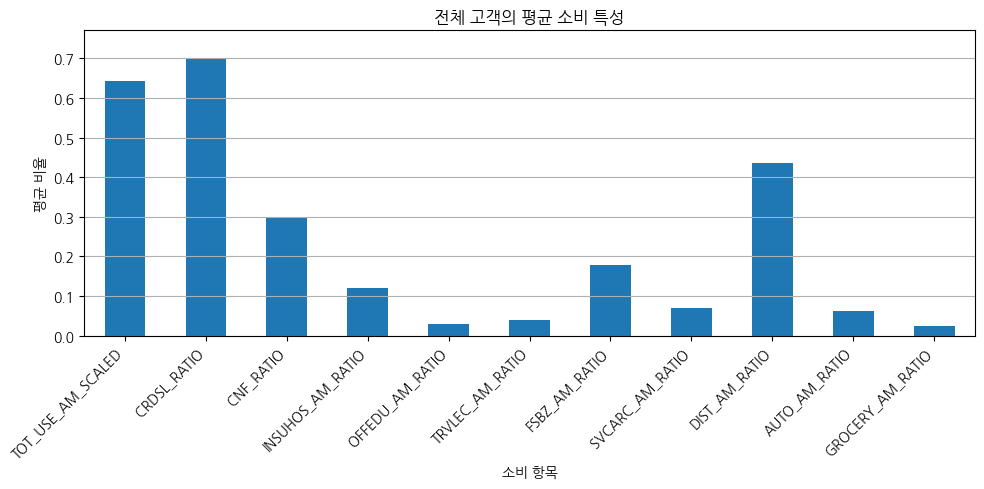

In [ ]:
# 1. 전체 고객의 소비특성 평균 계산
mean_profile = cluster[num_cols].mean()

# 2. 바 차트로 시각화
plt.figure(figsize=(10, 5))
mean_profile.plot(kind='bar')
plt.title('전체 고객의 평균 소비 특성')
plt.xlabel('소비 항목')
plt.ylabel('평균 비율')
plt.ylim(0, mean_profile.max() * 1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
mean_profile

,0
TOT_USE_AM_SCALED,0.643192
CRDSL_RATIO,0.700606
CNF_RATIO,0.299394
INSUHOS_AM_RATIO,0.120909
OFFEDU_AM_RATIO,0.029529
TRVLEC_AM_RATIO,0.039559
FSBZ_AM_RATIO,0.177772
SVCARC_AM_RATIO,0.069419
DIST_AM_RATIO,0.436691
AUTO_AM_RATIO,0.061718


### 클러스터별 소비 특성 평균

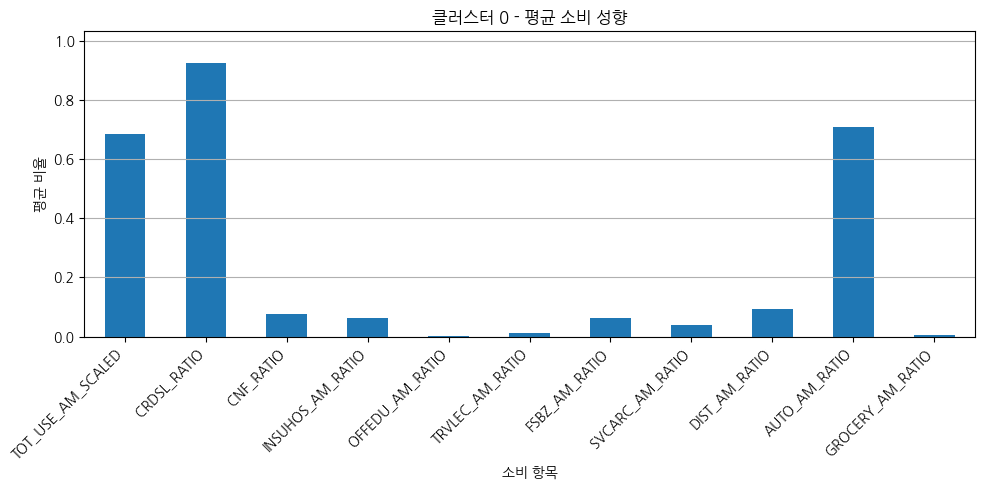

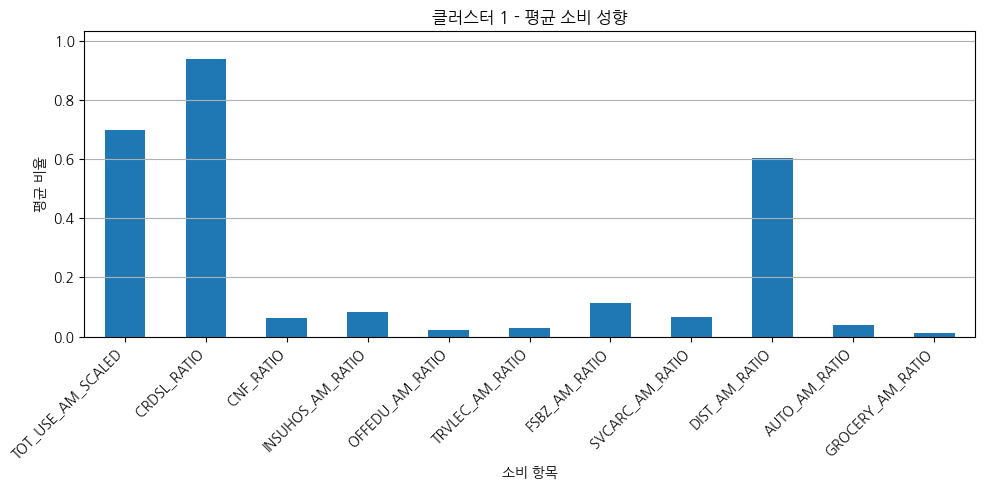

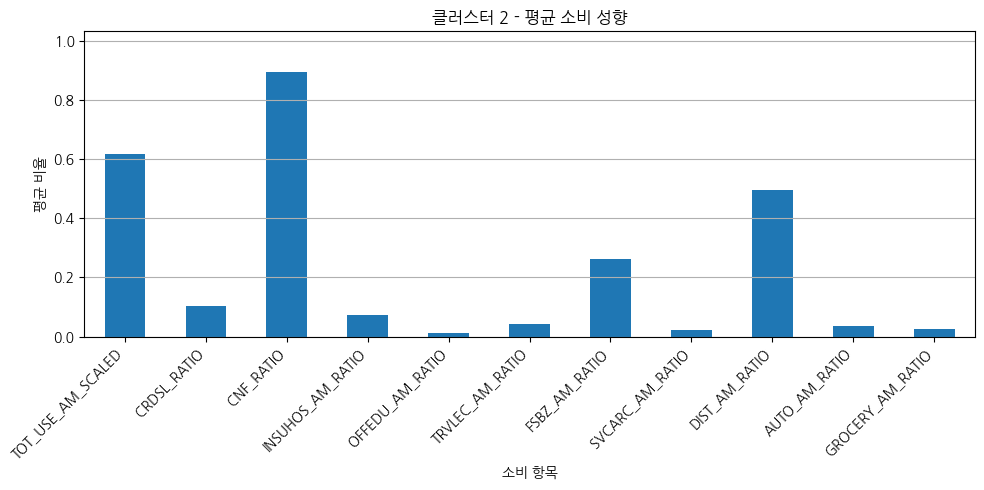

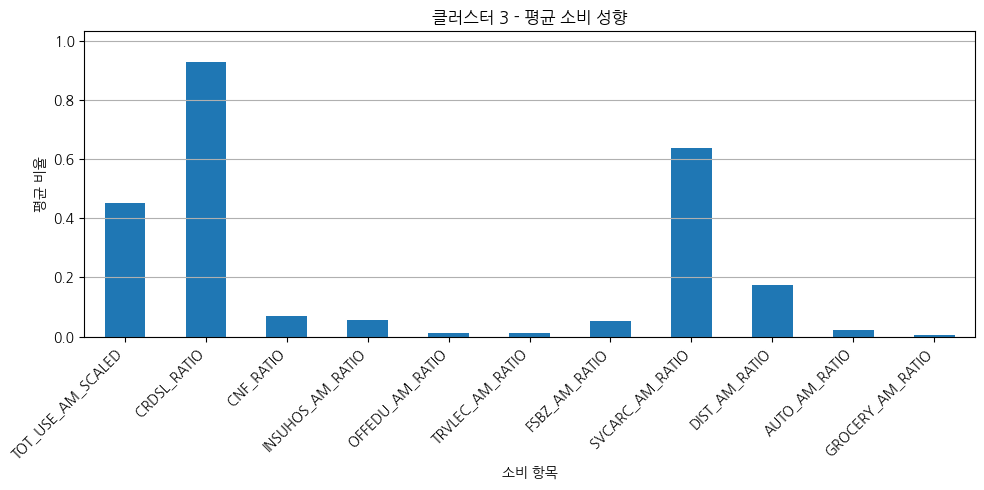

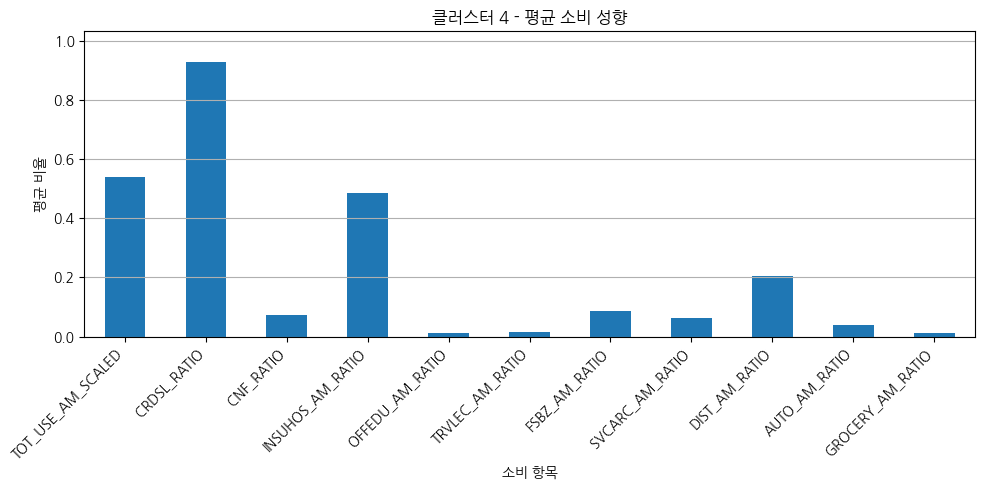

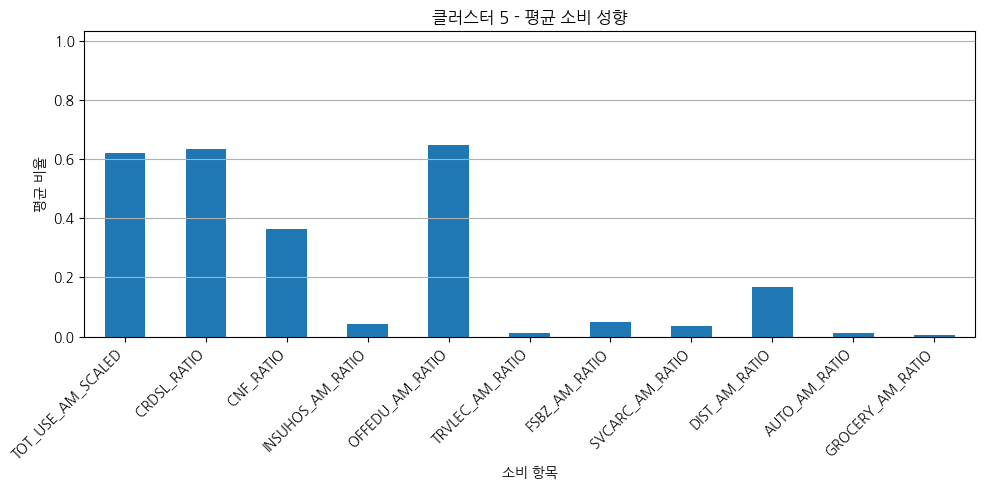

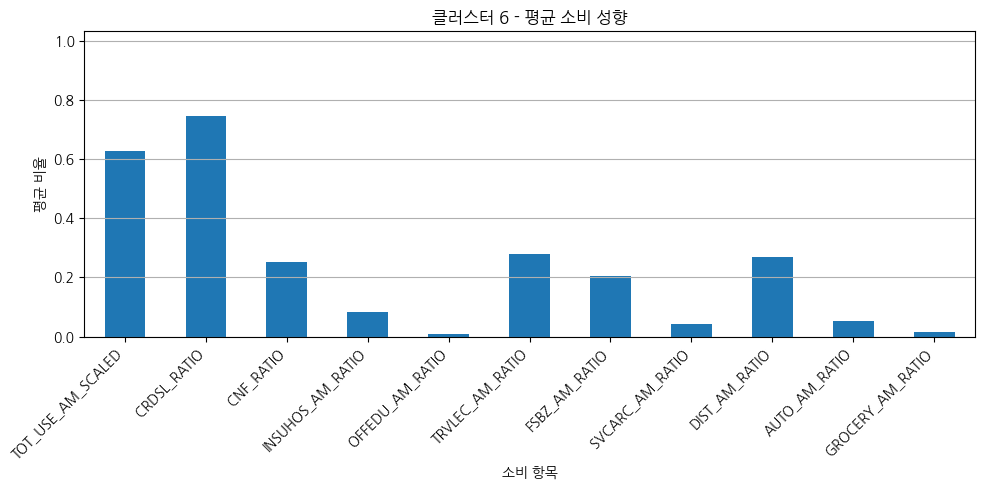

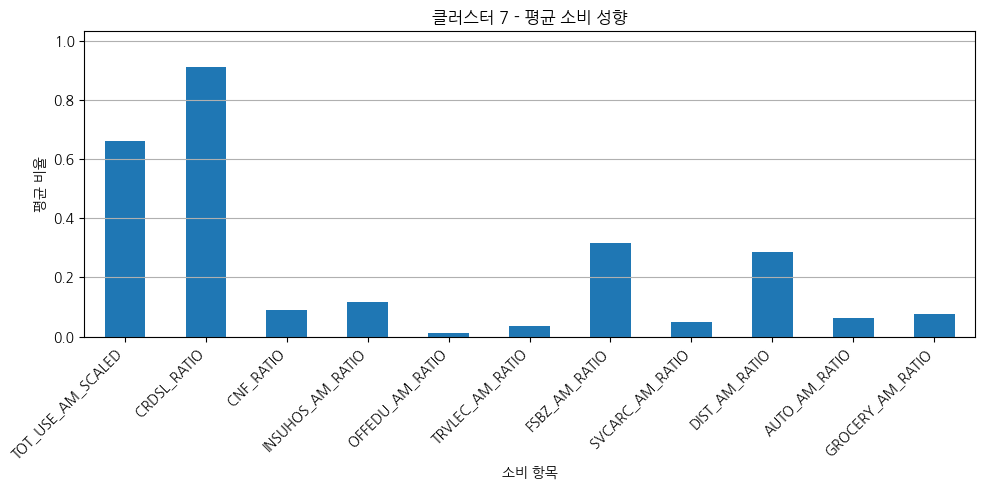

In [ ]:
# ✅ 12. 클러스터별 소비 특성 평균
cluster_profile = cluster.groupby("cluster")[num_cols].mean()

# 클러스터 개수 추출
n_clusters = cluster_profile.shape[0]

# 클러스터별 개별 시각화
for cluster_id in range(n_clusters):
    plt.figure(figsize=(10, 5))
    cluster_profile.loc[cluster_id].plot(kind='bar')
    plt.title(f"클러스터 {cluster_id} - 평균 소비 성향")
    plt.xlabel("소비 항목")
    plt.ylabel("평균 비율")
    plt.ylim(0, cluster_profile.max().max() * 1.1)  # y축 스케일 통일
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [ ]:
cluster_profile

,TOT_USE_AM_SCALED,CRDSL_RATIO,CNF_RATIO,INSUHOS_AM_RATIO,OFFEDU_AM_RATIO,TRVLEC_AM_RATIO,FSBZ_AM_RATIO,SVCARC_AM_RATIO,DIST_AM_RATIO,AUTO_AM_RATIO,GROCERY_AM_RATIO
cluster,,,,,,,,,,,
0,0.685646,0.923114,0.076886,0.062497,0.003196,0.011218,0.063323,0.037702,0.094480,0.707824,0.006346
1,0.696666,0.937598,0.062402,0.083952,0.021731,0.028874,0.112684,0.065433,0.602942,0.037847,0.012756
2,0.618542,0.104969,0.895031,0.072594,0.011430,0.042018,0.260903,0.022950,0.494702,0.036984,0.026376
3,0.450847,0.928589,0.071410,0.057581,0.012683,0.012588,0.053248,0.636569,0.175654,0.023612,0.005774
4,0.540963,0.926539,0.073461,0.484085,0.010875,0.016208,0.086514,0.062919,0.203346,0.038005,0.012677
5,0.620677,0.635408,0.364592,0.042147,0.648332,0.011965,0.049881,0.035027,0.168927,0.011782,0.006538
6,0.628359,0.746586,0.253414,0.083171,0.009018,0.277612,0.205659,0.043297,0.267751,0.051901,0.015967
7,0.660986,0.910409,0.089591,0.116043,0.011919,0.035800,0.315782,0.051075,0.285094,0.063426,0.076640


In [ ]:
mean_profile_T = mean_profile.transpose()
mean_profile_T

,0
TOT_USE_AM_SCALED,0.643192
CRDSL_RATIO,0.700606
CNF_RATIO,0.299394
INSUHOS_AM_RATIO,0.120909
OFFEDU_AM_RATIO,0.029529
TRVLEC_AM_RATIO,0.039559
FSBZ_AM_RATIO,0.177772
SVCARC_AM_RATIO,0.069419
DIST_AM_RATIO,0.436691
AUTO_AM_RATIO,0.061718


In [ ]:
df1 = cluster_profile.copy()
df2 = mean_profile_T.copy()

In [ ]:
df2 = df2.to_frame().T if isinstance(df2, pd.Series) else df2

df2.index = ['total']

df_combined = pd.concat([df1, df2])

#df_combined = df_combined.reset_index(drop=True)

In [ ]:
df_combined

,TOT_USE_AM_SCALED,CRDSL_RATIO,CNF_RATIO,INSUHOS_AM_RATIO,OFFEDU_AM_RATIO,TRVLEC_AM_RATIO,FSBZ_AM_RATIO,SVCARC_AM_RATIO,DIST_AM_RATIO,AUTO_AM_RATIO,GROCERY_AM_RATIO
0,0.685646,0.923114,0.076886,0.062497,0.003196,0.011218,0.063323,0.037702,0.094480,0.707824,0.006346
1,0.696666,0.937598,0.062402,0.083952,0.021731,0.028874,0.112684,0.065433,0.602942,0.037847,0.012756
2,0.618542,0.104969,0.895031,0.072594,0.011430,0.042018,0.260903,0.022950,0.494702,0.036984,0.026376
3,0.450847,0.928589,0.071410,0.057581,0.012683,0.012588,0.053248,0.636569,0.175654,0.023612,0.005774
4,0.540963,0.926539,0.073461,0.484085,0.010875,0.016208,0.086514,0.062919,0.203346,0.038005,0.012677
5,0.620677,0.635408,0.364592,0.042147,0.648332,0.011965,0.049881,0.035027,0.168927,0.011782,0.006538
6,0.628359,0.746586,0.253414,0.083171,0.009018,0.277612,0.205659,0.043297,0.267751,0.051901,0.015967
7,0.660986,0.910409,0.089591,0.116043,0.011919,0.035800,0.315782,0.051075,0.285094,0.063426,0.076640
total,0.643192,0.700606,0.299394,0.120909,0.029529,0.039559,0.177772,0.069419,0.436691,0.061718,0.025449


### 클러스터별 총 소비평균 + 전체소비평균

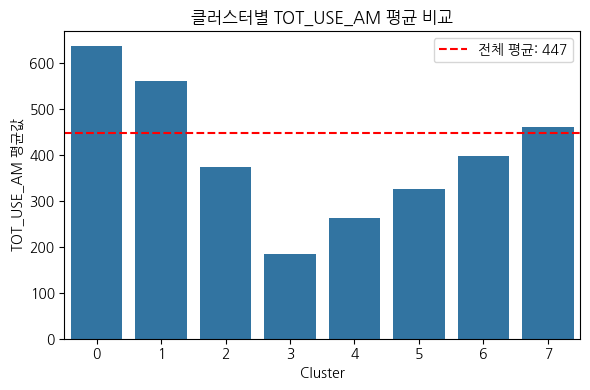

전체 평균 : 446.5489


In [ ]:
# 🧮 클러스터별 TOT_USE_AM 평균 계산
tot_use_mean = result.groupby('cluster')['TOT_USE_AM'].mean().reset_index()

# ✅ 전체 고객의 TOT_USE_AM 평균값 계산
overall_mean = result['TOT_USE_AM'].mean()

# 📊 시각화
plt.figure(figsize=(6, 4))
sns.barplot(data=tot_use_mean, x='cluster', y='TOT_USE_AM')
plt.axhline(overall_mean, color='red', linestyle='--', label=f'전체 평균: {overall_mean:,.0f}')
plt.title("클러스터별 TOT_USE_AM 평균 비교")
plt.xlabel("Cluster")
plt.ylabel("TOT_USE_AM 평균값")
plt.legend()
plt.tight_layout()
plt.show()

print("전체 평균 :", overall_mean)